# ReAct method

This notebook aims at evaluating the **ReAct method**.

**ReAct** method basically consists in re-using existing logit-based OOD methods, but with penultimate layer **activations clipped** to a certain threshold value. In practice, this threshold is set based on the $p$-th percentile of penultimate activations estimated on the ID data.

Here, we focus on a toy convolutional network trained on MNIST[0-4] challenged on MNIST[5-9].

**Reference**  
_React: Out-of-distribution detection with rectified activations._  
Sun, Yiyou, Chuan Guo, and Yixuan Li.  
Advances in Neural Information Processing Systems 34 (2021)  
<https://arxiv.org/pdf/2111.12797.pdf>

### Imports


In [1]:
%load_ext autoreload

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.methods import MLS, Energy, Entropy, ODIN
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import OODDataset
from oodeel.utils.tf_training_tools import train_tf_model

Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## MNIST[0-4] vs MNIST[5-9]

We train a toy convolutional network on the MNIST dataset restricted to digits 0 to 4. After fitting the train subset of this dataset to different OOD methods with react option enabled, we will compare the scores returned for MNIST[0-4] (in-distrubtion) and MNIST[5-9] (out-of-distribution) test subsets.

### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote core classes such as `OODDataset` and `OODBaseDetector`.


In [3]:
# === Load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]

# 1- Load train/test MNIST dataset
ds_train = OODDataset("mnist", load_kwargs=dict(split="train"))
data_test = OODDataset("mnist", load_kwargs=dict(split="test"))

# 2- Split ID / OOD data depending on label value:
# in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
ds_train, _ = ds_train.split_by_class(in_labels)
oods_in, oods_out = data_test.split_by_class(in_labels)


# 3- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


ds_train = ds_train.prepare(batch_size, preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size, preprocess_fn, with_ood_labels=False)
ds_out = oods_out.prepare(batch_size, preprocess_fn, with_ood_labels=False)

clear_output()

### Model training

Now let's train a simple model on MNIST[0-4] using `train_tf_model` function.


41/41 [==============================] - 2s 41ms/step - loss: 0.0135 - accuracy: 0.9955
Test accuracy:	0.9955

=== Penultimate features viz ===


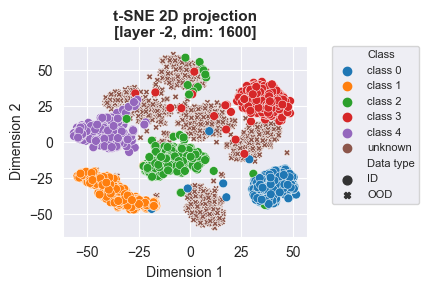

In [4]:
# === Train / Load model ===
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4.h5")

try:
    # if the model exists, load it
    model = tf.keras.models.load_model(model_path_mnist_04)
except OSError:
    # else, train a new model
    train_config = {
        "model": "toy_convnet",
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in,
    }

    model = train_tf_model(ds_train, **train_config)

_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### ReAct scores

We now fit some OOD detectors using ReAct + [MLS, MSP, Energy, Entropy, ODIN] with MNIST[0-4] train dataset, and compare OOD scores returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.

=== ODIN ===
~ Without react ~
auroc      0.876586
fpr95tpr   0.542129


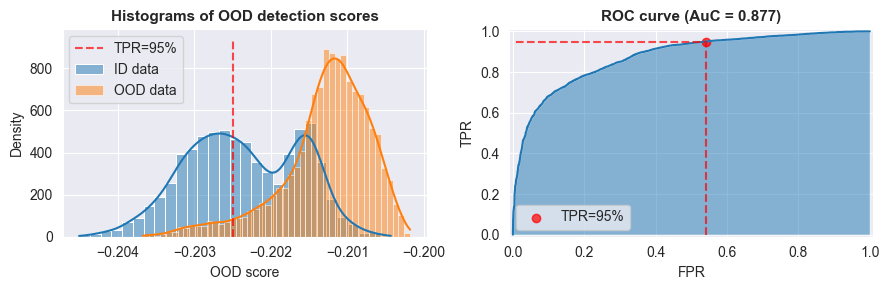

~ With react ~


In [8]:
%autoreload 2
detectors = {
    "odin": {
        "class": ODIN,
        "kwargs": dict(temperature=1000),
    },
    "mls": {
        "class": MLS,
        "kwargs": dict(),
    },
    "msp": {
        "class": MLS,
        "kwargs": dict(output_activation="softmax"),
    },
    "energy": {
        "class": Energy,
        "kwargs": dict(),
    },
    "entropy": {
        "class": Entropy,
        "kwargs": dict(),
    },
}

for d in detectors.keys():
    print(f"=== {d.upper()} ===")

    for use_react in [False, True]:
        print(["~ Without", "~ With"][int(use_react)] + " react ~")
        # === ood scores ===
        d_kwargs = detectors[d]["kwargs"]
        d_kwargs.update(dict(
            use_react=use_react,
            react_quantile=0.8,
        ))
        detector = detectors[d]["class"](**d_kwargs)
        detector.fit(model, fit_dataset=ds_train)
        scores_in, _ = detector.score(ds_in)
        scores_out, _ = detector.score(ds_out)

        # === metrics ===
        # auroc / fpr95
        metrics = bench_metrics(
            (scores_in, scores_out),
            metrics=["auroc", "fpr95tpr"],
        )
        for k, v in metrics.items():
            print(f"{k:<10} {v:.6f}")

        log_scale = d in ["msp", "entropy"]
        # hists / roc
        plt.figure(figsize=(9, 3))
        plt.subplot(121)
        if d == "msp":
            # Normalize scores for a better hist visualization
            minim = np.min([np.min(scores_in), np.min(scores_out)])
            scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
            scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
            plot_ood_scores(scores_in_, scores_out_, log_scale=log_scale)
        else:
            plot_ood_scores(scores_in, scores_out, log_scale=log_scale)
        plt.subplot(122)
        plot_roc_curve(scores_in, scores_out)
        plt.tight_layout()
        plt.show()